In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import cPickle
%matplotlib inline

### Loading of the data
The images can be obtained from: http://www.cs.toronto.edu/~kriz/cifar.html The 32x32 images are of have the following classes:

In [2]:
names = ['plane','auto','bird','cat','deer','dog','frog','horse','ship','truck']

In [3]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    data = dict['data']
    imgs = np.transpose(np.reshape(data,(-1,32,32,3), order='F'),axes=(0,2,1,3)) #order batch,x,y,color
    y = np.asarray(dict['labels'], dtype='uint8')
    return y, imgs

In [4]:
y, imgs = unpickle('/home/dueo/Dropbox/data/CIFAR-10/cifar-10-batches-py/test_batch')

In [5]:
#fig = plt.figure(figsize=(10,10))
#for i in range(10):
#    idx = np.where(y == i)[0]
#    for j in range(10):
#        fig.add_subplot(10,10,10*i+(j+1),xticks=[], yticks=[])
#        plt.imshow(imgs[idx[j]])

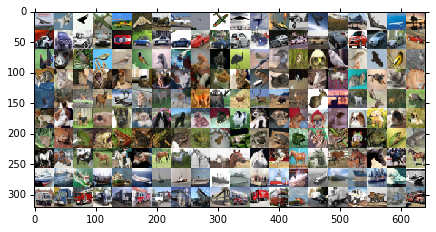

In [6]:
can = np.zeros((320,640,3),dtype='uint8')
for i in range(10):
    idx = np.where(y == i)[0]
    for j in range(20):
        can[32*i:32*(i+1),32*j:32*(j+1),:] = imgs[idx[j]]

fig = plt.figure(figsize=(7,14))
fig.xticks=[]
plt.imshow(can)
import scipy
scipy.misc.imsave('imgs/cifar_examples.jpg', can)

## Loading the features
The features have been extracted using a inception model V3 using the python script 'cifar-10_experiment.py'. We load the test data. For training we just take the first batch (we don't have to learn the features).

In [7]:
d = np.load('test_batch.npz')
y_test = d['y']
rep_test  = d['representations']
pred_test  = d['predictions']

d = np.load('data_batch_1.npz')
y_train = d['y']
rep_train = d['representations']

## Doing classification using a simple SVM
#### Learning
We learn on the first batch only

In [8]:
C = 0.1
svc = svm.SVC(kernel='linear', C=C).fit(rep_train,y_train)

In [9]:
res = svc.predict(rep_test)

In [10]:
np.sum(res == y_test)/10000.0

0.87419999999999998

### Who good are we?
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

Pretty impressive I would say.

# Miscellaneous

### Examples of missclassifications

In [12]:
wrong = np.where(y_test != res)[0] 

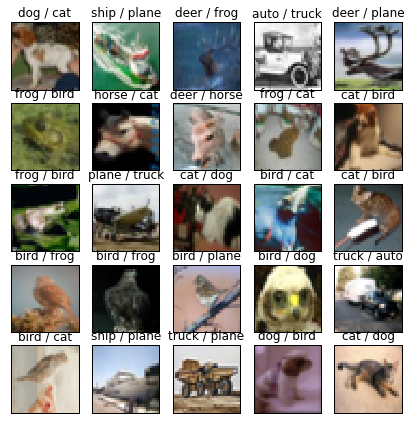

In [14]:
fig = plt.figure(figsize=(7,7))
for i in range(25):
    fig.add_subplot(5,5,(i+1),xticks=[], yticks=[])
    idx = wrong[i]
    plt.title("{} / {}".format(names[y_test[idx]], names[res[idx]]))
    plt.imshow(imgs[idx])
plt.savefig('imgs/cifar_misclassified.jpg')
#y_test[wrong[0:10]]

### How to choose the hyperparamteres

Below we play a bit around (on a subset of the training data) and choose the hyperparameter for the SVM. It turns out that a linear SVM is as good as one having a Gaussian kernel. We choose the linear one, since it is much simpler.

In [13]:
from __future__ import print_function

from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

n_samples = len(y)

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    rep_test[0:500], y_test[0:500], test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['linear'], 'C': [0.1, 1, 10, 100, 1000]},
                    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [0.1, 1, 10, 100, 1000]}]

score = 'accuracy'

print("# Tuning hyper-parameters for %s" % score)
print()

clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5,
                   scoring=score)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'kernel': 'rbf', 'C': 10, 'gamma': 0.001}

Grid scores on development set:

0.752 (+/-0.139) for {'kernel': 'linear', 'C': 0.1}
0.752 (+/-0.139) for {'kernel': 'linear', 'C': 1}
0.752 (+/-0.139) for {'kernel': 'linear', 'C': 10}
0.752 (+/-0.139) for {'kernel': 'linear', 'C': 100}
0.752 (+/-0.139) for {'kernel': 'linear', 'C': 1000}
0.152 (+/-0.095) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.001}
0.152 (+/-0.095) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.0001}
0.636 (+/-0.118) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
0.152 (+/-0.095) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.756 (+/-0.136) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
0.740 (+/-0.112) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
0.756 (+/-0.136) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001}
0.752 (+/-0.139) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}
0.756 (+/-0.136) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0